In [1]:
import os
import numpy as np
import cv2
import random
from keras import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import vgg16, vgg19
from keras.applications import densenet
from keras.applications.resnet50 import ResNet50 
#from keras.applications.vgg16 import preprocess_input as vgg_pi
from keras.applications import resnet50
#import preprocess_input as resnet_pi
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import GaussianNoise,MaxPool2D
from keras.regularizers import l2
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, MaxPooling2D,Conv2D, Dropout
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [13]:
img_dir = r'C:/Users/tetteh/Desktop/zindi comp/data/train/train'
test_dir = r'C:/Users/tetteh/Desktop/zindi comp/data/test'
IMG_SIZE = 224
batch_size = 32

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=60,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    rescale=1/255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #zca_whitening=True,
    horizontal_flip=True,
    vertical_flip =True,
    #fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

In [15]:
train_generator = train_datagen.flow_from_directory(
    #'C:/Users/tetteh/Desktop/zindi comp/data/train',
    img_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    classes =["leaf_rust", "stem_rust","healthy_wheat"],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)
validation_generator = train_datagen.flow_from_directory(
    img_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=batch_size,
    classes =["leaf_rust", "stem_rust","healthy_wheat"],
    class_mode='categorical',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(test_dir, classes=['test'],target_size=(IMG_SIZE,IMG_SIZE))

Found 701 images belonging to 3 classes.
Found 174 images belonging to 3 classes.
Found 610 images belonging to 1 classes.


## VGG16 pretrain Model with no regularization

#### Import VGG16 pretrain model with all the weights except for the last layer

In [16]:
#from keras.regularizers import l2
base_model = vgg16.VGG16(include_top=False,
                         input_shape=(224,224, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[0].trainable = False

This I added some extra dense layers and Gausian noise. I also used the elu activation function

In [32]:
x = base_model.output

x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x)

x = Dense(1024, activation='elu')(x)
x = Dense(256,activation='elu')(x)

x = Dense(3,  activation='softmax')(x)
model_vg166 = Model(inputs=base_model.input, outputs=x)


In [33]:
from keras.optimizers import SGD,Adagrad
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

ada= Adagrad(lr=0.001)

In [34]:
model_vg166.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="C:/Users/tetteh/Desktop/zindi comp/models/best_weights.hdf5", 
                               monitor = 'val_loss',
                               verbose=1, 
                               save_best_only=True)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,baseline=0.50)


In [35]:
history=model_vg166.fit_generator(train_generator, 
                           steps_per_epoch = len(train_generator.filenames)//batch_size,
                           #use_multiprocessing=True,
                           #shuffle=True,
                           validation_data = validation_generator,
                           validation_steps =len(validation_generator.filenames)//batch_size,
                           callbacks=[checkpointer],
                           epochs =50,
                           #class_weight=class_weights,
                           verbose =2)

Epoch 1/50
 - 118s - loss: 2.1322 - accuracy: 0.4051 - val_loss: 0.9786 - val_accuracy: 0.4062

Epoch 00001: val_loss improved from inf to 0.97857, saving model to C:/Users/tetteh/Desktop/zindi comp/models/best_weights.hdf5
Epoch 2/50
 - 115s - loss: 0.9891 - accuracy: 0.4978 - val_loss: 0.9283 - val_accuracy: 0.5141

Epoch 00002: val_loss improved from 0.97857 to 0.92826, saving model to C:/Users/tetteh/Desktop/zindi comp/models/best_weights.hdf5
Epoch 3/50
 - 115s - loss: 0.9226 - accuracy: 0.5247 - val_loss: 0.8967 - val_accuracy: 0.5704

Epoch 00003: val_loss improved from 0.92826 to 0.89674, saving model to C:/Users/tetteh/Desktop/zindi comp/models/best_weights.hdf5
Epoch 4/50
 - 112s - loss: 0.9246 - accuracy: 0.5396 - val_loss: 0.8060 - val_accuracy: 0.5704

Epoch 00004: val_loss improved from 0.89674 to 0.80598, saving model to C:/Users/tetteh/Desktop/zindi comp/models/best_weights.hdf5
Epoch 5/50
 - 111s - loss: 0.9019 - accuracy: 0.5620 - val_loss: 0.8621 - val_accuracy: 0.54

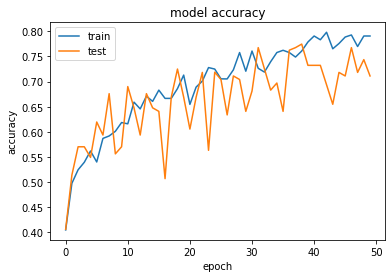

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


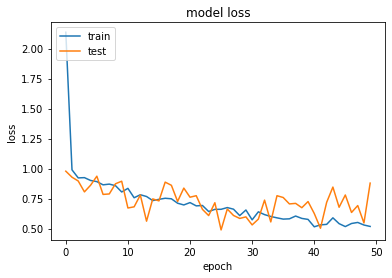

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### After training, I predicted with the final model output and also with the best weights saved with the checkpoint

Predicting with the final model output

In [ ]:
import pandas as pd
#model_vg166.load_weights('models/shapes_cnn.h5')
pred1 = model_vg166.predict(testD1)
prediction = pd.DataFrame(pred1, columns=["leaf_rust", "stem_rust","healthy_wheat"]).to_csv('./predictions/new1.csv')


Loading and predicting with the model with the least validation error saved with the checkpoint

In [ ]:
model_vg166.save('models/shapes_cnn.h5')
model_vg166.load_weights('models/best_weights.hdf5')



In [ ]:
import pandas as pd
pred2 = model_vg166.predict(testD1)

prediction = pd.DataFrame(pred2, columns=["leaf_rust", "stem_rust","healthy_wheat"]).to_csv('./predictions/new2.csv')

#pred = model3_vgg16.predict_generator(test_generator)

##### VGG16 pretrain model with dropout

In [38]:
from keras.regularizers import l2
base_model = vgg16.VGG16(include_top=False,
                         input_shape=(224,224, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[0].trainable = False

In [39]:
x1 = base_model.output

x1 = base_model.output
x1 = Flatten(name='flatten', input_shape=base_model.output_shape)(x1)
x1 = Dropout(0.5)(x1)
#x = GaussianNoise(0.1)(x)
x1 = Dense(1024, activation='elu')(x1)
x1 = Dense(256,activation='elu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(3,  activation='softmax')(x1)
model_vg166_dropout = Model(inputs=base_model.input, outputs=x1)

In [41]:
model_vg166_dropout.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
history=model_vg166_dropout.fit_generator(train_generator, 
                           steps_per_epoch = len(train_generator.filenames)//batch_size,
                           #use_multiprocessing=True,
                           #shuffle=True,
                           validation_data = validation_generator,
                           validation_steps =len(validation_generator.filenames)//batch_size,
                           callbacks=[checkpointer],
                           epochs =50,
                           #class_weight=class_weights,
                           verbose =2)

Epoch 1/50
 - 115s - loss: 1.8514 - accuracy: 0.3991 - val_loss: 0.9121 - val_accuracy: 0.6000

Epoch 00001: val_loss did not improve from 0.48888
Epoch 2/50
 - 116s - loss: 1.3782 - accuracy: 0.4335 - val_loss: 0.9434 - val_accuracy: 0.5493

Epoch 00002: val_loss did not improve from 0.48888
Epoch 3/50
 - 115s - loss: 1.3181 - accuracy: 0.4211 - val_loss: 0.8313 - val_accuracy: 0.5704

Epoch 00003: val_loss did not improve from 0.48888
Epoch 4/50
 - 112s - loss: 1.1643 - accuracy: 0.4595 - val_loss: 0.9268 - val_accuracy: 0.4859

Epoch 00004: val_loss did not improve from 0.48888
Epoch 5/50
 - 108s - loss: 1.2294 - accuracy: 0.4702 - val_loss: 1.0044 - val_accuracy: 0.5141

Epoch 00005: val_loss did not improve from 0.48888
Epoch 6/50
 - 109s - loss: 1.1439 - accuracy: 0.4963 - val_loss: 0.9626 - val_accuracy: 0.4437

Epoch 00006: val_loss did not improve from 0.48888
Epoch 7/50
 - 109s - loss: 1.1251 - accuracy: 0.4895 - val_loss: 0.8893 - val_accuracy: 0.5375

Epoch 00007: val_loss 

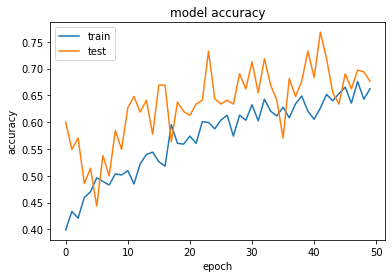

In [43]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

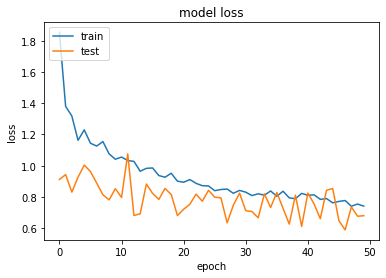

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### VGG16 pretrain model with L2 regularization and gaussian noise

In [45]:
x2 = base_model.output
x2 = Flatten(name='flatten', input_shape=base_model.output_shape)(x2)

x = GaussianNoise(0.1)(x)
x2 = Dense(1024, activation='elu')(x2)
x2 = Dense(256,kernel_regularizer=l2(0.001),activation='elu')(x2)

x2 = Dense(3,  activation='softmax')(x2)
model_vg166_l2 = Model(inputs=base_model.input, outputs=x2)

In [46]:
model_vg166_l2.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
history=model_vg166_l2.fit_generator(train_generator, 
                           steps_per_epoch = len(train_generator.filenames)//batch_size,
                           #use_multiprocessing=True,
                           #shuffle=True,
                           validation_data = validation_generator,
                           validation_steps =len(validation_generator.filenames)//batch_size,
                           callbacks=[checkpointer],
                           epochs =50,
                           #class_weight=class_weights,
                           verbose =2)

Epoch 1/50
 - 114s - loss: 1.8731 - accuracy: 0.4395 - val_loss: 1.2351 - val_accuracy: 0.5437

Epoch 00001: val_loss did not improve from 0.48888
Epoch 2/50
 - 114s - loss: 1.3815 - accuracy: 0.5037 - val_loss: 1.2354 - val_accuracy: 0.5282

Epoch 00002: val_loss did not improve from 0.48888
Epoch 3/50
 - 116s - loss: 1.3181 - accuracy: 0.5441 - val_loss: 1.3621 - val_accuracy: 0.5563

Epoch 00003: val_loss did not improve from 0.48888
Epoch 4/50
 - 116s - loss: 1.2815 - accuracy: 0.5964 - val_loss: 1.2590 - val_accuracy: 0.5915

Epoch 00004: val_loss did not improve from 0.48888
Epoch 5/50
 - 117s - loss: 1.2945 - accuracy: 0.5874 - val_loss: 1.0992 - val_accuracy: 0.6479

Epoch 00005: val_loss did not improve from 0.48888
Epoch 6/50
 - 107s - loss: 1.2283 - accuracy: 0.6099 - val_loss: 1.1300 - val_accuracy: 0.6338

Epoch 00006: val_loss did not improve from 0.48888
Epoch 7/50
 - 110s - loss: 1.2216 - accuracy: 0.6116 - val_loss: 1.2614 - val_accuracy: 0.6000

Epoch 00007: val_loss 

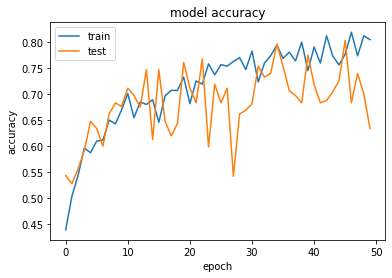

In [48]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

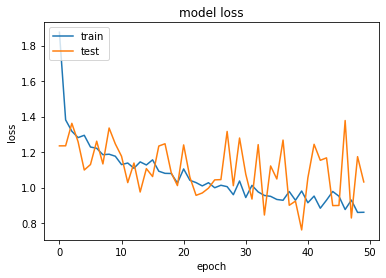

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

x = base_model.output

x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x)
x = Dropout(0.5)(x)
x = GaussianNoise(0.1)(x)
x = Dense(1024, activation='elu')(x)
x = Dropout(0.3)(x)
x = Dense(256,kernel_regularizer=l2(0.001), activation='elu')(x)
#x = Dense(64, activation='elu')(x)
x = Dense(3,  activation='softmax')(x)
model_vg166 = Model(inputs=base_model.input, outputs=x)

#kernel_regularizer=l2(0.01),
#model_vg166.summary()

In [ ]:
test_data=[]
import os
import cv2
IMG_SIZE=224
from tqdm import tqdm
import numpy as np
test1_dir = "./test/test"
def create_test_data():
    path = os.path.join(test1_dir)  
    #class_num = CATEGORIES.index(category)  
    print(path)

    for img in tqdm(os.listdir(path)):  
        try:
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            test_data.append([new_array])  # add this to our training_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass
            
create_test_data()


testD=np.array(test_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
testD1 = testD/255 
testD.shape

In [ ]:
train_data=[]
import os
import cv2
from tqdm import tqdm
import numpy as np
import random
IMG_SIZE=224
ddir = "./data/train/train"
CATEGORIES= ["leaf_rust", "stem_rust","healthy_wheat"]
def create_training_data():
    
    
    for category in CATEGORIES:  

        paths = os.path.join(ddir,category)  
        class_num = CATEGORIES.index(category) 

        for img in tqdm(os.listdir(paths)):
            try:
                img_array = cv2.imread(os.path.join(paths,img) ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                train_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
    
    
    
create_training_data()    
feature = []
labels = []
random.shuffle(train_data)
for features,label in train_data:
    feature.append(features)
    labels.append(label)
feature = np.array(feature).reshape(-1, IMG_SIZE, IMG_SIZE, 3)##reshaping features
ytrain = np.array(labels)
xtrain=feature/255

ytrain.shape
xtrain.shape

In [ ]:
import keras

ytrain= keras.utils.to_categorical(ytrain, num_classes=3, dtype='float32')

In [ ]:
ytrain.shape

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

In [ ]:
train_datagen.fit(X_train)

In [ ]:
history=model_vg166.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=16), 
                           steps_per_epoch = len(X_train)//16,
                           #use_multiprocessing=True,
                           #shuffle=True,
                           validation_data = datagen.flow(X_val, Y_val, batch_size=16),
                           validation_steps =len(X_val)//16,
                           callbacks=[checkpointer],
                           epochs =200,
                           #class_weight=class_weights,
                           verbose =2)

In [ ]:
from keras.regularizers import l2
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', input_shape=(224, 224, 3),
            activation='relu'))
model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten()) # Flatten the input
model.add(GaussianNoise(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(3,kernel_regularizer=l2(0.01), activation='softmax'))

from keras.optimizers import SGD,Adagrad,Adam
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

ada= Adagrad(lr=0.001)

optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)


model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", 
                               monitor = 'val_loss',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
from keras.regularizers import l2
base_model = resnet50.ResNet50(include_top=False,
                         input_shape=(224,224, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[0].trainable = False

x = base_model.output

x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x)
x = Dense(512, activation='elu')(x)
x = Dense(3,kernel_regularizer=l2(0.01),  activation='softmax')(x)
model_res = Model(inputs=base_model.input, outputs=x)
#model_res.summary()

In [ ]:
import os
os.listdir(img_dir)